<a href="https://colab.research.google.com/github/shail-paliwal/ECED4406_Assignment_Power_Analysis/blob/main/Copy_of_assignment_0x002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECED4406 Assignment 0x002 - Power Analysis for Password Bypass

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.


## ChipWhisperer Tutorial Links

This tutorial will use material from the ChipWhisperer project, see the https://github.com/newaetech/chipwhisperer-jupyter/tree/master/courses/sca101 folder. This tutorial follows tutorial 2.1B.

Note you can find the solution notebook as well there - if you get stuck on what code you should be running, see the notebook entitled "SOLN_Lab 2_1B - Power Analysis for Password Bypass.ipynb".

## Power Trace Gathering

At this point you've got to insert code to perform the power trace capture. To keep it easy, we are going to read the data from a file. You can define the filename to use here. Note there is a test file (with a known password) and one you've got to figure out for yourself. If you are running this on Google Colab, run the following block to download the files to your local instance:

In [35]:
%%bash
wget https://github.com/eced4406/power-analysis/raw/main/passwordtraces_known_h0px3.p
wget https://github.com/eced4406/power-analysis/raw/main/passwordtraces_unknown.p

--2022-11-21 17:12:35--  https://github.com/eced4406/power-analysis/raw/main/passwordtraces_known_h0px3.p
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/eced4406/power-analysis/main/passwordtraces_known_h0px3.p [following]
--2022-11-21 17:12:35--  https://raw.githubusercontent.com/eced4406/power-analysis/main/passwordtraces_known_h0px3.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48115834 (46M) [application/octet-stream]
Saving to: ‘passwordtraces_known_h0px3.p.2’

     0K .......... .......... .......... .......... ..........  0% 4.28M 11s
    50K .......... .......... .......... ........

In [74]:
#password_filename = "passwordtraces_known_h0px3.p" #<-- The password should be h0px3
password_filename = "passwordtraces_unknown.p" #<-- Use this once the code works

In [76]:
import pickle
import random
import time

traces_to_load = pickle.load(open(password_filename, "rb"))

def cap_pass_trace(pass_guess):
    if pass_guess.endswith("\n") is False:
        raise ValueError("Password guess must end with \\n")
        
    pass_guess = pass_guess.strip("\n")
    
   # known_passwd = "h0px3"
    known_passwd = "dal20"
        
    trylist = "abcdefghijklmnopqrstuvwxyz0123456789 \x00"
    
    if len(pass_guess) > 5:
        raise ValueError("Only guesses up to 5 chars recorded, sorry about that.")
        
    for a in pass_guess:
        if a not in trylist:
            raise ValueError("Part of guess (%c) not in recorded enumeration list (%s)"%(a, trylist))
            
    #Only recorded is correct passwords
    recorded_pw = ""
    for i in range(0, len(pass_guess)):
        if known_passwd[i] != pass_guess[i]:
            recorded_pw += " "
        else:
            recorded_pw += pass_guess[i]
            
    time.sleep(0.05)
            
    return traces_to_load[recorded_pw][random.randint(0, 99)]

## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `h` to something else.

If you need a reminder of how to do a plot - see the matplotlib section of the **Jupyter Introduction** notebook.

The following cell shows you how to capture one power trace with `h` sent as a password. From there:

1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device. We're only going to look at the difference between a password starting with `h` and something else right now.
3. Plot the different waveforms.

[ 0.0546875  -0.12207031 -0.09472656 ... -0.02636719  0.03222656
  0.0390625 ]


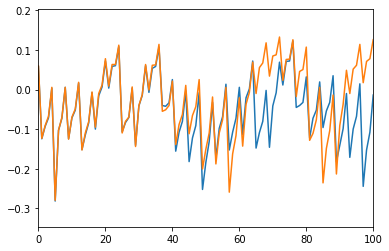

In [77]:
import matplotlib.pylab as plt

#Example - capture 'h' - end with newline '\n' as serial protocol expects that
#trace_h = cap_pass_trace("h\n")#changed to d from h
trace_d = cap_pass_trace("d\n")
#print(trace_h)
print(trace_d)


# ###################
# Add your code here
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cap_pass_trace("d\n"))#changed to d from h
plt.plot(cap_pass_trace("0\n"))

plt.xlim([0,100])#comment this out to show full plot

plt.show()
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

For reference, the output should look something like this:
<img src="https://github.com/eced4406/power-analysis/blob/main/img/spa_password_h_vs_0_overview.png?raw=1" alt="SPA of Power Analysis" width="450"/>

If you are using the `%matplotlib notebook` magic, you can zoom in at the start. What you want to notice is there is two code paths taken, depending on a correct or incorrect path. Here for example is a correct & incorrect character processed:
<img src="https://github.com/eced4406/power-analysis/blob/main/img/spa_password_h_vs_0_zoomed.png?raw=1" alt="SPA of Power Analysis" width="450"/>

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 500 samples of the power trace.

---
📝**Plotting Note**

If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.

---

  0%|          | 0/36 [00:00<?, ?it/s]

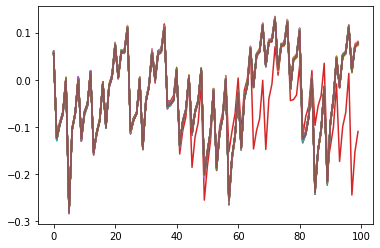

In [78]:
# ###################
# Add your code here
from tqdm.notebook import tqdm
plt.figure()
for c in tqdm('abcdefghijklmnopqrstuvwxyz0123456789'):
    trace_d = cap_pass_trace(c + "\n")
    plt.plot(trace_d[0:100])
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis.

<img src="https://github.com/eced4406/power-analysis/blob/main/img/spa_password_list_char1.png?raw=1" alt="SPA of Power Analysis against all inputs" width="450"/>

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("h" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

In [79]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("\x00\n")[0:500]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c\n")[0:500]
plt.plot(other_trace)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password.

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace - ref_trace)

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


In [89]:
# ###################
# Add your code here
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("h0p\x00\n")[0:500]

for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
   # trace = cap_pass_trace('h0p' + c + "\n")[0:500]
    trace = cap_pass_trace(c + "\n")[0:500]
    plt.plot(trace - ref_trace)
    plt.show()
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="https://github.com/eced4406/power-analysis/blob/main/img/spa_password_diffexample.png?raw=1" alt="SPA with Difference" width="450"/>
    

What do do now? Let's make this thing automatically detect such a large difference. Some handy stuff to try out is the `np.sum()` and `np.abs()` function.

The first one will get absolute values:

```python
import numpy as np
np.abs([-1, -3, 1, -5, 6])

    Out[]: array([1, 3, 1, 5, 6])
```

The second one will add up all the numbers.

```python
import numpy as np    
np.sum([-1, -3, 1, -5, 6])

    Out[]: -2
```

Using just `np.sum()` means positive and negative differences will cancel each other out - so it's better to do something like `np.sum(np.abs(DIFF))` to get a good number indicating how "close" the match was.


In [82]:
import numpy as np
np.abs([-1, -3, 1, -5, 6])

array([1, 3, 1, 5, 6])

In [83]:
import numpy as np
np.sum([-1, -3, 1, -5, 6])

-2

In [84]:
np.sum(np.abs([1, 3, 1, 5, 6]))

16

Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))

In [86]:
# ###################
# Add your code here
ref_trace = cap_pass_trace( "dal\x00\n")

for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
    trace = cap_pass_trace("dal" + c + "\n")
    diff = np.sum(np.abs(trace - ref_trace))
    
    print("{:1} diff = {:2}".format(c, diff))
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

a diff = 8.3740234375
b diff = 7.712890625
c diff = 5.1982421875
d diff = 6.7001953125
e diff = 6.3095703125
f diff = 5.7392578125
g diff = 5.9677734375
h diff = 5.4169921875
i diff = 5.8583984375
j diff = 5.6083984375
k diff = 6.8603515625
l diff = 4.68359375
m diff = 6.4404296875
n diff = 5.01171875
o diff = 6.7001953125
p diff = 7.037109375
q diff = 6.484375
r diff = 7.015625
s diff = 5.927734375
t diff = 5.4541015625
u diff = 6.8095703125
v diff = 6.4404296875
w diff = 6.6474609375
x diff = 6.322265625
y diff = 6.484375
z diff = 7.794921875
0 diff = 5.98046875
1 diff = 8.2548828125
2 diff = 187.9921875
3 diff = 6.1650390625
4 diff = 5.7822265625
5 diff = 5.4560546875
6 diff = 6.484375
7 diff = 6.6015625
8 diff = 7.712890625
9 diff = 6.7861328125


Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 5 times (max password size):
        
        ref_trace = capture power trace(guessed_pw + "\x00\n")
        
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER + newline)
            diff = SUM(ABS(trace - ref_trace))
            
            if diff > THRESHOLD:
                
                guessed_pwd += c
                print(guessed_pw)
                
                break


In [87]:
# ###################
# Add your code here

guessed_pw = ""


for _ in range(0, 5):  

    ref_trace = cap_pass_trace(guessed_pw + "\x00\n")
    
    for c in 'abcdefghijklmnopqrstuvwxyz0123456789': 
        trace = cap_pass_trace(guessed_pw + c + "\n")
        diff = np.sum(np.abs(trace - ref_trace))

        if diff > 40.0:
            guessed_pw += c
            print(guessed_pw)
            break

# ###################
#raise NotImplementedError("Add your code here, and delete this.")

d
da
dal
dal2
dal20


You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below. If you get really stuck, check the `SOLN` version.

Once you run this - you should be able to run it for the "secret" file.

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get 'h'

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")